In [1]:
from iris import time, cube
import cis
from cis import read_data, read_data_list, get_variables, data_io
from cis.data_io import gridded_data
from cis.data_io.gridded_data import make_from_cube
from cis.time_util import PartialDateTime
from cis import plotting
from cis.plotting import plot
from cis.plotting.plot import drawbluemarble, multilayer_plot, taylor_plot

import os
from datetime import datetime
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import copy
from flight_py_tools import FAAM

from dateutil.relativedelta import relativedelta
import numpy as np
import numpy.ma as ma
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

In [2]:
# Directory containing raw aircraft data and names of variables to plot
inputdir1='/shared/netscratch/mrr32/Flight_work/Flights/'
varname1='O3_TECO' ; source1='FAAM' ; variable1='Ozone' ; units1='(ppbv)'
# Position of date characters in the filename string
# Plugin to be used by cis.read_data
aircraft_plugin='FAAM'
# Directory containing model data on flight track and names of variables to plot
inputdir2='/shared/netscratch/mrr32/Flight_work/Outdir/'
varname2='m01s51i001' ; source2='UKCA' ; variable2='Ozone' ; units2='(ppbv)'
stash='51001' ; cfactor=1.e9/1.657
# Directory to store plots
outdir='/home/am2688/nethome/Plots/'
# colors for colorbars (from https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3):
# Diverging: blue to red (9 colours)
blue_to_red =['#313695','#4575b4','#74add1','#abd9e9','#ffffff','#fdae61','#f46d43','#d73027','#a50026'] 
# Diverging: green to magenta (9 colours)
green_to_magenta = ['#276419','#4d9221','#7fbc41','#b8e186','#ffffff','#f1b6da','#de77ae','#c51b7d','#8e0152']
# Sequential: yellow to red (7 colours)
yellow_to_red = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']

In [3]:
# Read all Obs
infile1=inputdir1+'*.nc'
obs=cis.read_data(infile1,varname1,product='FAAM')

In [4]:
# Read all Model data
infile2=inputdir2+'*'+'stash'+stash+'*'
mod=cis.read_data(infile2,varname2,product='FAAM')

In [5]:
# Extract np arrays from variables masked arrays
# This is necessary to avoid errors whilst operating on the variables
obs.data=ma.getdata(obs.data)
mod.data=ma.getdata(mod.data)
for cc in range(len(obs._coords)) :
    obs._coords[cc].data=ma.getdata(obs._coords[cc].data)
    mod._coords[cc].data=ma.getdata(mod._coords[cc].data)

In [6]:
#remove negative and nans using masked arrays
obs.data=ma.masked_less_equal(obs.data, 0)
obs.data=ma.masked_invalid(obs.data)
#obs.data=ma.masked_greater_equal(obs.data, 90)
# Convert model data to ppbv
mod.data=mod.data*cfactor

# Subset Model and Obs
# Boundary layer (BL): 0-1km
BL_obs=obs.subset(z=[0.,1000.])
BL_mod=mod.subset(z=[0.,1000.])
# Lower Troposphere (LT): 0-6km
LT_obs=obs.subset(z=[0.,6000.])
#LT_obs.data=ma.masked_greater_equal(LT_obs.data, 90)
LT_mod=mod.subset(z=[0.,6000.])
# Tropical Upper Troposphere (TUT): 6-13km and 30S:30N
TUT_obs=obs.subset(z=[6000.,13000.],y=[-30.,30.])
#TUT_obs.data=ma.masked_greater_equal(TUT_obs.data, 90)
TUT_mod=mod.subset(z=[6000.,13000.],y=[-30.,30.])
# Mid-latitude Upper Troposphere/Lower Stratosphere: 6-13km and 30N:90N
UTLS_obs=obs.subset(z=[6000.,13000.],y=[30.,90.])
#UTLS_obs.data=ma.masked_greater_equal(UTLS_obs.data, 170)
#UTLS_obs=ma.masked_less_equal(UTLS_obs.data, 0)
#UTLS_obs=ma.masked_invalid(UTLS_obs.data)
UTLS_mod=mod.subset(z=[6000.,13000.],y=[30.,90.])

# Create Model - Obs difference
#diff=obs.copy()
#diff.data=mod.data-obs.data

# Subset difference
#BL_diff=diff.subset(z=[0.,1000.])
BL_diff=BL_mod.data-BL_obs.data
#LT_diff=diff.subset(z=[1000.,6000.])
LT_diff=LT_mod.data-LT_obs.data
#TUT_diff = diff.subset(z=[6000.,13000.],y=[-30.,30.])
TUT_diff=TUT_mod.data-TUT_obs.data
#UTLS_diff = diff.subset(z=[6000.,13000.],y=[30.,90.])    
UTLS_diff=UTLS_mod.data-UTLS_obs.data

In [7]:
print(len(LT_mod.data))
print(len(LT_obs.data))

7578099
7578099


In [8]:
#print(min(obs.data),max(obs.data),min(TUT_diff.data),max(TUT_diff.data))
#print(obs.data.min,obs.data.max,TUT_diff.data.min,TUT_diff.data.max)
print(ma.MaskedArray.min(LT_obs.data))


0.01


In [9]:
print(min(LT_mod.data))
#print(min(LT_mod.data))
#print(min(LT_obs.data))
print(ma.MaskedArray.min(LT_diff))
print(ma.MaskedArray.min(LT_obs.data))

nan
nan
0.01


IOStream.flush timed out


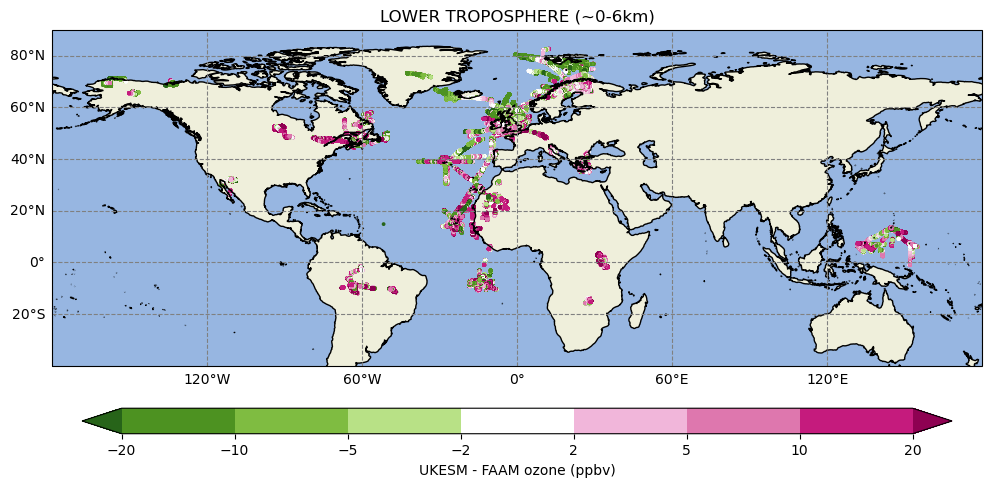

In [10]:
### DIFFERENCE PLOT for Lower Troposphere

#extract data and coordinates from cis var
lon=(LT_obs._coords[3].data)
lat=(LT_obs._coords[2].data)
data=(LT_diff)

# Define figure and size
fig = plt.figure(figsize=(12, 17))
# Define Axes (ax1) and choose cartopy projection for map 
# See here for more projections: https://earth-env-data-science.github.io/lectures/mapping_cartopy.html
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
# Add cartopy features
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND)    # optional: edgecolor='black'
# Or add bluemarble background
#ax1.bluemarble()
# Or add stock image
#ax1.stock_img()
# Add coastlines
ax1.coastlines(resolution='50m')  # coastline resolution options are '110m', '50m', '10m'
# Define region to plot as [lon1,lon2,lat1,lat2] (default=global plot)
ax1.set_extent([-179.9,179.9,-40,90], crs=ccrs.PlateCarree())
# Set title for the plot
ax1.set_title('LOWER TROPOSPHERE (~0-6km)')
# Plot gridlines and grid labels (choose color and style of gridlines)
gl=ax1.gridlines(draw_labels=True,color='grey',linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set levels and choose color scale
mylev_diff=[-20,-10,-5,-2,2,5,10,20]
clrmap_diff = matplotlib.colors.ListedColormap(green_to_magenta)                                            
# get discrete colormap
norm_diff = matplotlib.colors.BoundaryNorm(mylev_diff, clrmap_diff.N, extend='both')

# Add data
ax1.scatter(lon, lat, c=data, norm=norm_diff,cmap=clrmap_diff, s=3 )
# Get position/size of plot and work out position/size of colorbar relative to plot
pos1 = ax1.get_position() 
pos2 = [pos1.x0 + 0.025, pos1.y0 - 0.04,  pos1.width -0.025*2, 0.015] 

#add colorbar as a separate axes
ax2 = fig.add_axes(pos2)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=clrmap_diff,
                                norm=norm_diff,
                                orientation='horizontal')

cb2.set_label('UKESM - FAAM ozone (ppbv)')

plt.savefig(outdir+'LT_diff.png',dpi=300,bbox_inches='tight')

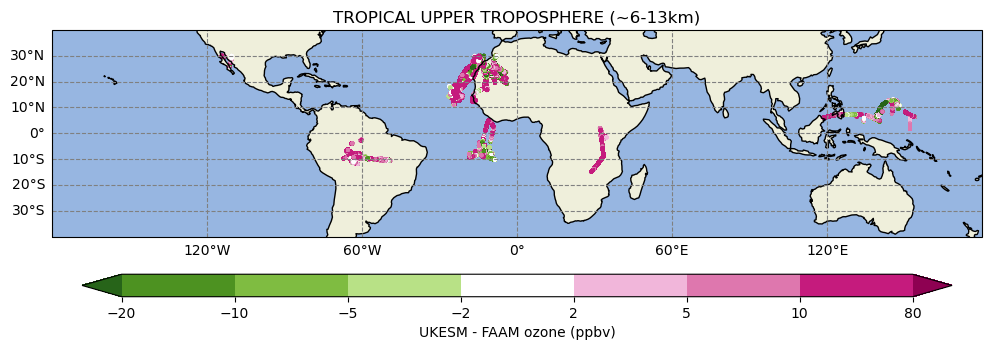

In [11]:
### DIFFERENCE PLOT for Tropical Upper Troposphere

#extract data and coordinates from cis var
lon=(TUT_obs._coords[3].data)
lat=(TUT_obs._coords[2].data)
data=(TUT_diff)

# Define figure and size
fig = plt.figure(figsize=(12, 15))
# Define Axes (ax1) and choose cartopy projection for map 
# See here for more projections: https://earth-env-data-science.github.io/lectures/mapping_cartopy.html
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
# Add cartopy features
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND)    # optional: edgecolor='black'
# Or add bluemarble background
#ax1.bluemarble()
# Or add stock image
#ax1.stock_img()
# Add coastlines
ax1.coastlines(resolution='110m')  # coastline resolution options are '110m', '50m', '10m'
# Define region to plot as [lon1,lon2,lat1,lat2] (default=global plot)
ax1.set_extent([-179.9,179.9,-40,40], crs=ccrs.PlateCarree())
# Set title for the plot
ax1.set_title('TROPICAL UPPER TROPOSPHERE (~6-13km)')
# Plot gridlines and grid labels (choose color and style of gridlines)
gl=ax1.gridlines(draw_labels=True,color='grey',linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set levels and choose color scale
mylev_diff=[-20,-10,-5,-2,2,5,10,80]
clrmap_diff = matplotlib.colors.ListedColormap(green_to_magenta)                                            
# get discrete colormap
norm_diff = matplotlib.colors.BoundaryNorm(mylev_diff, clrmap_diff.N, extend='both')

# Add data
ax1.scatter(lon, lat, c=data, norm=norm_diff,cmap=clrmap_diff, s=3 )
# Get position/size of plot and work out position/size of colorbar relative to plot
pos1 = ax1.get_position() 
pos2 = [pos1.x0 + 0.025, pos1.y0 - 0.04,  pos1.width -0.025*2, 0.015] 

#add colorbar as a separate axes
ax2 = fig.add_axes(pos2)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=clrmap_diff,
                                norm=norm_diff,
                                orientation='horizontal')

cb2.set_label('UKESM - FAAM ozone (ppbv)')

plt.savefig(outdir+'TUT_diff.png',dpi=300,bbox_inches='tight')

In [ ]:
### DIFFERENCE PLOT for Mid-Latitude UTLS

#extract data and coordinates from cis var
lon=ma.getdata(UTLS_obs._coords[3].data)
lat=ma.getdata(UTLS_obs._coords[2].data)
data=ma.getdata(UTLS_diff)

# Define figure and size
fig = plt.figure(figsize=(12, 17))
# Define Axes (ax1) and choose cartopy projection for map 
# See here for more projections: https://earth-env-data-science.github.io/lectures/mapping_cartopy.html
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
# Add cartopy features
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAND)    # optional: edgecolor='black'
# Or add bluemarble background
#ax1.bluemarble()
# Or add stock image
#ax1.stock_img()
# Add coastlines
ax1.coastlines(resolution='110m')  # coastline resolution options are '110m', '50m', '10m'
# Define region to plot as [lon1,lon2,lat1,lat2] (default=global plot)
ax1.set_extent([-160,40,20,90], crs=ccrs.PlateCarree())
# Set title for the plot
ax1.set_title('MID-LATITUDE UTLS (~6-13km)')
# Plot gridlines and grid labels (choose color and style of gridlines)
gl=ax1.gridlines(draw_labels=True,color='grey',linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set levels and choose color scale
mylev_diff=[-20,-10,-5,-2,2,5,10,20]
clrmap_diff = matplotlib.colors.ListedColormap(green_to_magenta)                                            
# get discrete colormap
norm_diff = matplotlib.colors.BoundaryNorm(mylev_diff, clrmap_diff.N, extend='both')

# Add data
ax1.scatter(lon, lat, c=data, norm=norm_diff,cmap=clrmap_diff, s=3 )
# Get position/size of plot and work out position/size of colorbar relative to plot
pos1 = ax1.get_position() 
pos2 = [pos1.x0 + 0.025, pos1.y0 - 0.04,  pos1.width -0.025*2, 0.015] 

#add colorbar as a separate axes
ax2 = fig.add_axes(pos2)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=clrmap_diff,
                                norm=norm_diff,
                                orientation='horizontal')

cb2.set_label('UKESM - FAAM ozone (ppbv)')

plt.savefig(outdir+'UTLS_diff.png',dpi=300,bbox_inches='tight')